# Reliability benchmarking

In [1]:
import itertools
import numpy as np
from scipy.spatial import distance
import time
import tqdm

In [2]:
R = 100 # Bootstrap repetitions
k = 10 # Number of seeds to choose

num_gids = 1000
num_sims = 30
T = 16000
np.random.seed(0)
spike_signals = np.random.rand(num_gids, num_sims, T)
spike_signals2 = np.array([spike_signals[:, sidx, :] for sidx in range(num_sims)])

### v1: Loop over bootstrap samples, GIDs, and sim pairs

In [3]:
def reliability(v1, v2):
    """Computes reliability of two spike trains."""
    norm_prod = np.linalg.norm(v1) * np.linalg.norm(v2)
    if norm_prod > 0.0:
        return np.dot(v1, v2) / norm_prod
    else:
        return 0.0


def avg_reliability(v_filt):
    """Computes average reliability between all pairs of spike trains."""
    N_trials = v_filt.shape[0]
    avg_rel = 0.0
    for i in range(N_trials):
        for j in range(i + 1, N_trials):
            avg_rel = avg_rel + reliability(v_filt[i, :], v_filt[j, :])
    avg_rel = 2 * avg_rel / (N_trials * (N_trials - 1))
    return avg_rel

In [4]:
np.random.seed(0)
for ridx in tqdm.tqdm(range(R)):
    sel_idx = np.random.choice(num_sims, k, replace=False)
    reliab = np.array([avg_reliability(spike_signals[gidx, sel_idx, :]) for gidx in range(num_gids)])

100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


### v2: Loop over boostrap samples and sim pairs for matrices of GIDs

In [5]:
def reliability2(v1, v2):
    """v1/v2: spike signals of two simulations/set of neurons.  Arrays of size # neurons x # time_bins"""
    product_of_norms = (np.linalg.norm(v1, axis=1) * np.linalg.norm(v2, axis=1))
    mask_to_normalize_non_zero = (product_of_norms != 0)
    reliability = (v1 * v2).sum(axis=1)
    reliability[mask_to_normalize_non_zero] = reliability[mask_to_normalize_non_zero] / product_of_norms[
        mask_to_normalize_non_zero]
    return reliability


def avg_reliability2(v_filt):
    """Computes average reliability between all pairs of trials of a give set.
    v_filt: Array spike trains many simuations of shape N_trials x #neurons # time_bins"""
    N_trials = v_filt.shape[0]
    avg_rel = np.zeros(v_filt.shape[1])
    for i in range(N_trials):
        for j in range(i + 1, N_trials):
            avg_rel = avg_rel + reliability2(v_filt[i, :, :], v_filt[j, :, :])
    avg_rel = 2 * avg_rel / (N_trials * (N_trials - 1))
    return avg_rel


In [6]:
np.random.seed(0)
for ridx in tqdm.tqdm(range(R)):
    sel_idx = np.random.choice(num_sims, k, replace=False)
    reliab2 = avg_reliability2(spike_signals2[sel_idx, :, :])

100%|██████████| 100/100 [13:48<00:00,  8.29s/it]


### v3: Loop over GIDs & using scipy's distance function

In [7]:
def avg_reliability3(v_filt):
    """Computes average reliability between all pairs of trials of a give set.
        v_filt: Array spike trains many simuations of shape N_trials x #neurons # time_bins"""
    no_cells=v_filt.shape[1]
    mean_rels=[(1-distance.pdist(v_filt[:,x,:],'cosine')).mean() for x in range(no_cells)]
    return np.array(mean_rels)

In [8]:
np.random.seed(0)
for ridx in tqdm.tqdm(range(R)):
    sel_idx = np.random.choice(num_sims, k, replace=False)
    reliab3 = avg_reliability3(spike_signals2[sel_idx, :, :])

100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


### v4: Loop over bootstrap samples and GIDs, and optimized cosine similarity function (Andras Ecker's code)

In [9]:
# Andras Ecker's implementation from https://github.com/andrisecker/assemblyfire
from scipy.spatial.distance import squareform
def cosine_similarity(x):
    """Cosine similarity between rows of matrix
    much faster than `1 - squareform(pdist(x, metrix="cosine"))`"""
    x_norm = x / np.linalg.norm(x, axis=-1)[:, np.newaxis]
    return np.dot(x_norm, x_norm.T)

def avg_reliability4(v_filt):
    sim_matrix = cosine_similarity(v_filt)
    # squareform implements its inverse if the input is a square matrix (but the diagonal has to be 0.)
    np.fill_diagonal(sim_matrix, 0)  # stupid numpy...
    r_spikes = np.mean(squareform(sim_matrix))
    return r_spikes

In [10]:
np.random.seed(0)
for ridx in tqdm.tqdm(range(R)):
    sel_idx = np.random.choice(num_sims, k, replace=False)
    reliab4 = np.array([avg_reliability4(spike_signals[gidx, sel_idx, :]) for gidx in range(num_gids)])

100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


In [11]:
print(f'Max. reliability differences: {np.max(np.abs(reliab - reliab2))}, {np.max(np.abs(reliab - reliab3))}, {np.max(np.abs(reliab - reliab4))}')

Max. reliability differences: 5.551115123125783e-16, 9.992007221626409e-16, 4.440892098500626e-16


### Test inner function

In [65]:
num_gids = 100

np.random.seed(0)
v_filt1 = np.random.rand(num_gids, T)
v_filt2 = np.random.rand(num_gids, T)

In [66]:
#v1
t0 = time.time()
rel1 = [reliability(v_filt1[gidx, :], v_filt2[gidx, :]) for gidx in range(num_gids)]
print(f'Elapsed time: {1e3 * (time.time() - t0):.3f}ms')

Elapsed time: 3.367ms


In [67]:
# v2
t0 = time.time()
rel2 = reliability2(v_filt1, v_filt2)
print(f'Elapsed time: {1e3 * (time.time() - t0):.3f}ms')

Elapsed time: 10.542ms


In [69]:
print(f'Max. reliability difference: {np.max(np.abs(rel1 - rel2))}')

Max. reliability difference: 4.440892098500626e-16


In [98]:
num_gids_list = [10, 100, 1000, 10000]
t1_ms = np.full(len(num_gids_list), np.nan)
t2_ms = np.full(len(num_gids_list), np.nan)
for idx, num_gids in enumerate(num_gids_list):
    np.random.seed(0)
    v_filt1 = np.random.rand(num_gids, T)
    v_filt2 = np.random.rand(num_gids, T)
    #v1
    t0 = time.time()
    rel1 = [reliability(v_filt1[gidx, :], v_filt2[gidx, :]) for gidx in range(num_gids)]
    t1_ms[idx] = 1e3 * (time.time() - t0)
    # v2
    t0 = time.time()
    rel2 = reliability2(v_filt1, v_filt2)
    t2_ms[idx] = 1e3 * (time.time() - t0)

    assert np.allclose(rel1, rel1)

In [99]:
print('t1 (ms): ' + ', '.join([f'{t:.3f}' for t in t1_ms]))
print('t2 (ms): ' + ', '.join([f'{t:.3f}' for t in t2_ms]))

t1 (ms): 1.402, 3.520, 35.815, 355.499
t2 (ms): 0.987, 12.927, 175.652, 1796.744


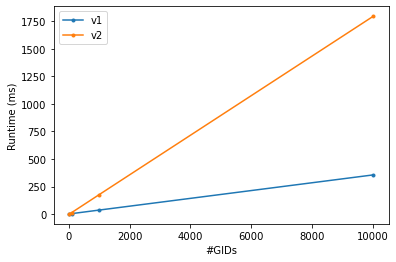

In [100]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(num_gids_list, t1_ms, '.-', label='v1')
plt.plot(num_gids_list, t2_ms, '.-', label='v2')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('#GIDs')
plt.ylabel('Runtime (ms)')
plt.legend()
plt.show()